# CartPole任务简介

CartPole（倒立摆）是强化学习领域的经典基准任务。

## 任务目标
想象有一根杆子竖直地固定在一辆可以左右移动的小车上。你的目标是通过控制小车向左或向右移动，始终让杆子保持竖直、不要倒下。

- 每一步，智能体只能选择：
  - 向左推小车
  - 向右推小车
- 杆子一旦倾斜角度过大或小车跑出边界，游戏就结束。
- 每维持一帧杆子不倒，都会获得+1奖励。

## 任务意义
CartPole任务考察了智能体的决策能力、平衡控制能力和对延迟奖励的学习能力。它是强化学习算法（如DQN、Policy Gradient等）入门和验证的首选环境。

**简而言之：CartPole就是让智能体学会“如何通过左右移动小车，让杆子尽可能久地不倒下”。**


## 马尔可夫决策过程（MDP）与CartPole
CartPole环境本质上是一个马尔可夫决策过程（MDP）：
- **状态（State）**：状态观测值有四个，就是小车的位置，即小车的位置，速度，倾斜角度和角度的变化速度。当位置和角度倾斜超出范围，则环境终止。
- **动作（Action）**：环境的动作是一维的，能取两个值0和1。取0代表把小车往左移动，取1代表把小车往右边移动。env.step(action)表示执行动作，函数会返回下一个状态st+1，奖励值reward，以及环境终止符done。
- **奖励（Reward）**：环境的奖励设置是每个时步下能维持杆不到就给一个 +1 的奖励，因此理论上在最优策略下这个环境是没有终止状态的，因为最优策略下可以一直保持杆不倒。但是基于 TD 的算法都必须要求环境有一个终止状态，所以在这里设置了一个环境的最大步数，超出最大步数则done=true。
- **转移（Transition）**：下一个状态只依赖于当前状态和动作（马尔可夫性）



## 价值迭代与奖励迭代的思想
强化学习的目标是最大化累计奖励。
- **价值函数（Value Function）**：衡量在某状态下，未来能获得的期望累计奖励。
- **Q值（动作价值函数）**：Q(s, a) 表示在状态s下采取动作a后，未来能获得的期望累计奖励。
- **价值迭代**：通过贝尔曼方程反复更新Q值，逐步逼近最优Q*。
- **奖励迭代**：每一步都用当前获得的奖励和下一个状态的价值来更新Q值。

## DQN如何实现价值迭代
DQN用神经网络近似Q(s, a)，并通过经验回放和目标网络实现稳定的价值迭代：
1. 智能体与环境交互，采集(s, a, r, s', done)五元组，存入经验池（ReplayBuffer）。
2. 随机采样一批经验，计算目标Q值：
   $$Q_{target} = r + \gamma \max_{a'} Q_{target}(s', a')$$
3. 用均方误差损失（MSELoss）优化Q网络，使其输出Q(s, a)更接近目标Q值。
4. 反复迭代，Q网络逐步学会每个状态-动作的长期价值。



常用代码：
- 导入库：import gym
- 创造环境：env = gym.make('env_name')
- 重置环境，并返回一个状态：state, info = env.reset(seed) 


In [1]:
import gym
import math, random, collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import os

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# DQN算法简介

DQN（Deep Q-Network）是一种结合了深度学习和Q-learning的强化学习算法。
- 用神经网络近似Q(s, a)，解决了传统Q表无法处理高维状态空间的问题。
- 采用ε-greedy策略平衡探索与利用。
- 通过经验回放（ReplayBuffer）打破数据相关性，提高训练稳定性。
- 使用目标网络（Target Network）缓解训练过程中的不稳定。

DQN的核心就是利用马尔可夫链的价值迭代思想，不断用当前奖励和下一个状态的最大Q值来更新当前Q值。

> 采用经验回放的原因：
> - 所有的四元组(st,at,rt,st+1)在用完之后就丢掉了，造成经验的浪费。(实际上这里代码保存的是五元组，还有环境的终止符done，因为DQN在估计Q值的时候需要用到这个终止符)
> - t时刻的四元组为(st,at,rt,st+1)，更新策略的时候，st和st+1有很强相关性，这种相关性实际上是有害的，我们希望打散这种相关性，从而使得训练效果更好。

In [2]:
# 经验回放有很多写法，这里用的是一个双端队列。
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

# ϵ−greedy策略

贪心动作总是最大化眼前的收益，不去尝试。ϵ−greedy选择以ϵ概率随机尝试，剩下的概率贪心来选取动作。非常简单的平衡探索(Explotation)和利用(Exploitation)的思想是通过确保整个过程随机来实现的。实际上就是随机和贪心相结合。在前期增强了探索增加探索性，后期减少探索增加训练稳定性。

举个例子，机器去学一个未知的东西，它用一个复杂的方法完成了它，但是呢它故步自封不去采取新的方案，一直以为那个方案好，这就是陷入了局部最优，前期没有探索就只会在一个很局限的区域去选择固定的狭隘方案，难以得到好的训练效果。同样的，后期探索多就得不到一个稳定的训练成果

# 模型结构

这个任务中采用的模型是MLP前馈神经网络，输入一个状态维度的张量，返回一个动作维度的张量，输出张量的每一个维度代表那个动作的q值。

此外卷积模型常用于图像分类，因为图像返回一个多维的张量（`height*weight*3`，3是rgb图像的特征），可以更好处理图像信息。

In [3]:
class DQN(object):
    def __init__(self, cfg):
        self.action_dim = 2  # CartPole环境的动作维度
        self.state_dim = 4   # CartPole环境的状态维度 
        self.device = cfg.device
        self.gamma = cfg.gamma
        self.batch_size = cfg.batch_size
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.sample_count = 0
        self.epsilon = self.epsilon_start
        
        # 初始化经验回放
        self.memory = ReplayBuffer(cfg.memory_capacity)
        
        # 初始化网络
        self.policy_net = MLP(self.state_dim, self.action_dim, cfg.hidden_dim).to(self.device)
        self.target_net = MLP(self.state_dim, self.action_dim, cfg.hidden_dim).to(self.device)
        
        # 将策略网络的参数复制到目标网络
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        # 优化器
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr)
    
    def sample_action(self, state):
        """ε-greedy策略选择动作"""
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                        math.exp(-1. * self.sample_count / self.epsilon_decay)
        
        if random.random() > self.epsilon:
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item()  # 选取最大Q值对应的动作
        else:
            action = random.randrange(self.action_dim)  # 随机选取动作
        return action
    
    def predict_action(self, state):
        """预测动作（不使用随机探索）"""
        with torch.no_grad():
            state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
            q_values = self.policy_net(state)
            action = q_values.max(1)[1].item()
        return action
    
    def update(self):
        """更新网络参数"""
        if len(self.memory) < self.batch_size:  # 经验回放中不满足一个批量时，不更新策略
            return
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        
        # 计算当前状态(s_t,a)对应的Q(s_t, a)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        
        # 计算下一时刻的状态(s_t_,a)对应的Q值
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1 - done_batch)
        
        # 计算均方根损失
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))
        
        # 优化更新模型
        self.optimizer.zero_grad()
        loss.backward()
        
        # clip防止梯度爆炸
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        
        self.optimizer.step()

In [4]:
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 训练流程
在每个训练回合里：不断通过ϵ−greedy策略来选取动作直到环境返回done，但因为这里训练到后期环境并不会返回done，设置了一个max_steps=200，执行200次动作后自动返回done。奖励的计算是在一个回合中执行的所有动作的奖励和。

In [5]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward, next_state, terminated))  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        if (i_ep + 1) % cfg.target_update == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if (i_ep + 1) % 10 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，Epislon：{agent.epsilon:.3f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

## 一次训练
刚从replay buffer中取出来时，state_batch,action_batch,reward_batch,next_state_batch,done_batch都是一个batch_size大小的元组，为了方便训练先要把他们转换为Tensor张量。

state_batch本来是batch_size大小的元组，每个元素都是一个四维的张量，np.array(state_batch)把它转化成一个（batch_size，state_dim）大小的array，再将他转换成tensor（batch_size，state_dim）。

action_batch也是一个batch_size大小的元组每个元素都是一个数字（0或1），代表取的动作。unsqueeze(1)能增加一个维度，确保tensor中每个分量都是tensor而不是一个数。

q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)代表当前状态对应执行了动作的q值。其中self.policy_net(state_batch)返回一个（batch_size，action_dim）大小的张量，.gather(dim=1, index=action_batch)则从这个张量的第一个维度（列），根据实际执行的action，从action_dim这个维度上选取对应action的q值，最后返回一个（batch_size，1）的值。

next_q_values = self.target_net(next_state_batch).max(1)[0].detach()则是在st+1状态中选取最大值的动作来计算下一个动作的q值。.detach()是分离梯度的操作，pytorch中如果希望这个变量的梯度不被计算，则把它分离出来，这里next_q_values是为了q网络估计出来的q_values更准确，本身梯度不应该被计算，因此这个变量在loss中被看作常数。

各个变量的维度和取值：（batch_size=64，state_dim=4）

# 绘图
通过gym提供的rab_array可以把游戏的每一帧保存下来。最后可以通过imageio库来变成动图保存。

# 测试函数
测试训练好的智能体在环境中的表现，记录每个回合的奖励和步数。

In [6]:
def test(cfg, env, agent):
    """测试智能体"""
    print("开始测试！")
    rewards = []
    steps = []
    
    for i_ep in range(cfg.test_eps):
        ep_reward = 0
        ep_step = 0
        state, info = env.reset(seed=cfg.seed)
        
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.predict_action(state)  # 使用贪心策略
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            ep_reward += reward
            
            if terminated:
                break
        
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"测试回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}，步数：{ep_step}")
    
    print("完成测试！")
    return {'rewards': rewards, 'steps': steps}

In [7]:
import imageio

def save_agent_gif(cfg, agent, save_path='./results', gif_filename='cartpole_dqn.gif'):
    """保存智能体运行的动图"""
    # 创建环境
    env = gym.make('CartPole-v1', render_mode='rgb_array')
    
    # 创建保存目录
    os.makedirs(save_path, exist_ok=True)
    
    frames = []  # 设置动图的帧列表
    
    # 重置环境
    state, info = env.reset(seed=cfg.seed)
    
    for step in range(cfg.max_steps):
        # 渲染当前帧
        render_frame = env.render()
        frames.append(render_frame)
        
        # 使用智能体选择动作
        action = agent.predict_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        state = next_state
        
        # 如果游戏结束，退出循环
        if terminated:
            break
    
    # 保存为gif
    gif_path = os.path.join(save_path, gif_filename)
    imageio.mimsave(gif_path, frames, fps=30)
    print(f"动图已保存到: {gif_path}")
    
    env.close()
    return gif_path

# 超参数设置


In [ ]:
class Config:
    def __init__(self) -> None:
        self.algo_name = 'DQN'  # 算法名称
        self.env_id = 'CartPole-v1'  # 环境id
        self.seed = 1  # 随机种子，便于复现，0表示不设置
        self.train_eps = 100  # 训练的回合数
        self.test_eps = 20  # 测试的回合数
        self.max_steps = 200  # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.95  # 折扣因子
        self.epsilon_start = 0.95  # e-greedy策略中初始epsilon
        self.epsilon_end = 0.01  # e-greedy策略中的终止epsilon
        self.epsilon_decay = 500  # e-greedy策略中epsilon的衰减率
        self.memory_capacity = 100000  # 经验回放池的容量
        self.hidden_dim = 256  # 神经网络的隐藏层维度
        self.batch_size = 64  # 批次大小
        self.target_update = 4  # 目标网络的更新频率
        self.lr = 0.001  # 学习率
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检测gpu

# 主函数
整合训练、测试和可视化的完整流程。

算法: DQN
环境: CartPole-v1
设备: cuda
开始训练！
回合：10/100，奖励：11.00，Epislon：0.687
回合：10/100，奖励：11.00，Epislon：0.687
回合：20/100，奖励：18.00，Epislon：0.481
回合：20/100，奖励：18.00，Epislon：0.481
回合：30/100，奖励：19.00，Epislon：0.325
回合：30/100，奖励：19.00，Epislon：0.325
回合：40/100，奖励：23.00，Epislon：0.229
回合：40/100，奖励：23.00，Epislon：0.229
回合：50/100，奖励：200.00，Epislon：0.027
回合：50/100，奖励：200.00，Epislon：0.027
回合：60/100，奖励：200.00，Epislon：0.010
回合：60/100，奖励：200.00，Epislon：0.010
回合：70/100，奖励：193.00，Epislon：0.010
回合：70/100，奖励：193.00，Epislon：0.010
回合：80/100，奖励：176.00，Epislon：0.010
回合：90/100，奖励：169.00，Epislon：0.010
回合：100/100，奖励：169.00，Epislon：0.010
完成训练！
开始测试！
测试回合：1/20，奖励：180.00，步数：180
测试回合：2/20，奖励：180.00，步数：180
测试回合：3/20，奖励：180.00，步数：180
测试回合：4/20，奖励：180.00，步数：180
测试回合：5/20，奖励：180.00，步数：180
测试回合：6/20，奖励：180.00，步数：180
测试回合：7/20，奖励：180.00，步数：180
测试回合：8/20，奖励：180.00，步数：180
测试回合：9/20，奖励：180.00，步数：180
测试回合：10/20，奖励：180.00，步数：180
测试回合：11/20，奖励：180.00，步数：180
测试回合：12/20，奖励：180.00，步数：180
测试回合：13/20，奖励：180.00，步数：180
测试回合：14/20，奖励：180.00，步数

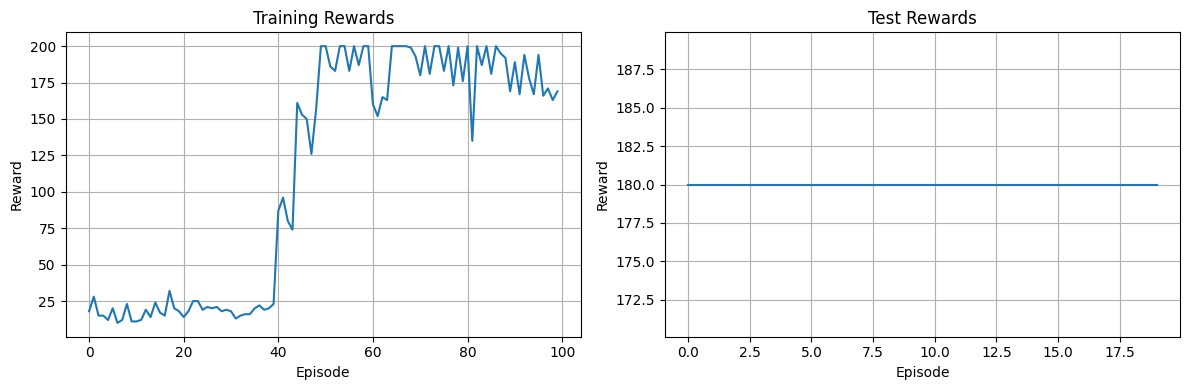

动图已保存到: ./results\cartpole_dqn.gif
训练平均奖励: 112.92
测试平均奖励: 180.00


In [9]:
def main():
    """主函数：完整的DQN训练流程"""
    # 初始化配置
    cfg = Config()
    
    # 设置随机种子
    torch.manual_seed(cfg.seed)
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    
    # 创建环境
    env = gym.make(cfg.env_id)
    
    # 创建智能体
    agent = DQN(cfg)
    
    print("=" * 50)
    print(f"算法: {cfg.algo_name}")
    print(f"环境: {cfg.env_id}")
    print(f"设备: {cfg.device}")
    print("=" * 50)
    
    # 训练
    train_results = train(cfg, env, agent)
    
    # 测试
    test_results = test(cfg, env, agent)
    
    # 绘制训练曲线
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_results['rewards'])
    plt.title('Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_results['rewards'])
    plt.title('Test Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 保存动图
    save_agent_gif(cfg, agent)
    
    print(f"训练平均奖励: {np.mean(train_results['rewards']):.2f}")
    print(f"测试平均奖励: {np.mean(test_results['rewards']):.2f}")
    
    return agent, train_results, test_results

# 运行主函数
if __name__ == "__main__":
    agent, train_results, test_results = main()

# 使用说明

## 快速开始
1. **运行所有单元格**：依次执行上面的所有代码单元格
2. **开始训练**：执行主函数单元格将自动开始训练过程
3. **查看结果**：训练完成后会自动显示训练曲线和保存动图

## 自定义运行
如果您想要自定义参数或分步运行，可以：

```python
# 1. 创建配置和环境
cfg = Config()
env = gym.make('CartPole-v1')

# 2. 创建智能体
agent = DQN(cfg)

# 3. 训练智能体
train_results = train(cfg, env, agent)

# 4. 测试智能体
test_results = test(cfg, env, agent)

# 5. 保存动图
save_agent_gif(cfg, agent)
```

## 参数调整
您可以在`Config`类中调整以下参数：
- `train_eps`: 训练回合数
- `test_eps`: 测试回合数  
- `lr`: 学习率
- `gamma`: 折扣因子
- `epsilon_start/epsilon_end/epsilon_decay`: ε-greedy策略参数
- `batch_size`: 批次大小
- `hidden_dim`: 隐藏层维度